In [1]:
suppressMessages(library(car))
suppressMessages(library(effects))
suppressMessages(library(emmeans))

# Follow-up Tests
In our previous lesson, we ran through all the main steps needed the fit and interpret an ANOVA, using the linear models framework. Putting aside all the debate about how to form the omnibus test, let us say that we have settled on a single approach (hopefully Type II). Unfortunately, these tests may still not have told us everything we wanted to know about our data. Although we began by justifying omnibus tests on the grounds of multiple comparisons, if an omnibus tests points towards an interesting effect we still want to know exactly *which* means are driving it. This is the realm of *follow-up tests*, which will be our focus in this section and which will finalise the steps needed for a complete ANOVA-style analysis.

## Motivating Example
To start with, let us see an example of the situation where follow-up tests are desired. To do so, we will follow the typical analysis steps of:

1. Fitting the model using `lm()`
2. Checking and dealing with all the assumptions to our satisfaction
3. Calling `summary()` on the model and interpreting the output 
4. Calling `Anova()` on the model and interpreting the output

We will use the same full-factorial model of `mtcars` from last week. However, we will increase the complexity by including the `origin` variable with *three* levels (`Japan`, `USA` and `Europe`). So, we now have a $2 \times 3$ ANOVA model and our means table is

|                     | Origin: Europe   |  Origin: Japan  | Origin: USA   | 
|---------------------|------------------|-----------------| --------------|
| **Shape: Straight** | Europe, Straight | Japan, Straight | USA, Straight | 
| **Shape: V-shaped** | Europe, V-shaped | Japan, V-shaped | USA, V-shaped | 

To make this example more useful, we will again engineer a fake interaction by increasing the value of MPG for the `(Japan, V-Shaped)` cell alone. The code for this is given in the drop-down below.

In [2]:
data(mtcars)

# Origin factor
mtcars$origin <- c('Japan','Japan','USA','USA','USA','USA','USA','Europe','Europe',
                   'Europe','Europe','Europe','Europe','Europe','USA','USA','USA',
                   'Europe','Japan','Japan','Japan','USA','USA','USA','USA',
                   'Europe','Europe','Europe','USA','Europe','Europe','Europe')
mtcars$origin <- as.factor(mtcars$origin)

# VS factor
vs.lab <- rep("",length(mtcars$vs)) 
vs.lab[mtcars$vs == 0] <- "V-shaped"
vs.lab[mtcars$vs == 1] <- "Straight"
mtcars$vs <- as.factor(vs.lab)

# Create fake interaction
mpg.fake          <- mtcars$mpg                  # copy mpg
mpg.idx           <- mtcars$origin == "Japan" &
                     mtcars$vs     == "V-shaped" # index of Japan-VShaped cell
mpg.fake[mpg.idx] <- mpg.fake[mpg.idx] + 15      # add constant to all data from that cell
mtcars$mpg.fake   <- mpg.fake   

The modelling steps are as follows 

In [3]:
# 1. Fit full factorial model
mod <- lm(mpg.fake ~ origin + vs + origin:vs, data=mtcars)

# 2. Check assumptions (and deal with them) 
# plot(mod)
# ...

# 3. Call summary() on the final model
# summary(mod)

# 4. Generate ANOVA table
print(Anova(mod))

Anova Table (Type II tests)

Response: mpg.fake
          Sum Sq Df F value    Pr(>F)    
origin    663.27  2 19.2594 7.391e-06 ***
vs         99.32  1  5.7681   0.02376 *  
origin:vs 181.55  2  5.2715   0.01197 *  
Residuals 447.70 26                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


For the sake of brevity, we have skipped the diagnostic plots and printing the regression output. So, just based on the ANOVA table, what can we conclude? Sticking with NHST for now, we can see a significant omnibus interaction effect ($F_{2,26} = 5.27, p < 0.05$). As these are Type II tests, we will ignore the main effects and just work on understanding the interaction. Conceptually, we can think of this effect as indicating that the difference in MPG between `Straight` and `V-Shaped` engines depends upon whether the car came from `Japan`, `USA` or `Europe`[^interact-foot].

So, we are now at the point that we ended on last week. However, it seems we still have some unanswered questions. Because the interaction is an *omnibus* test, it does not tell us *which* differences are driving the effect. We can conclude that the country of origin appears to change how MPG differs between the two engine shapes, but surely we want to know *how* this actually occurs? Which countries show the largest difference? Are there any countries where the engine shape makes little difference to MPG? Is this effect driven only by one country or are there multiple countries?

We could get some of the way towards answering these questions by simply *plotting* the effect. So let us have a look at the interaction using an effects plot

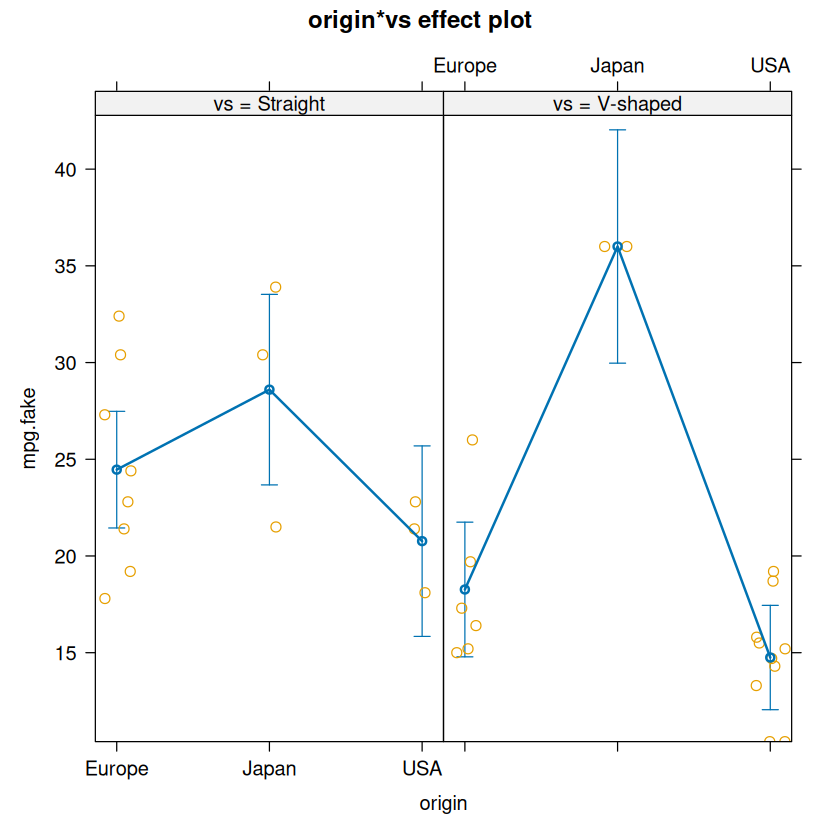

In [4]:
plot(effect("origin:vs", mod, residuals=TRUE), partial.residuals=list(smooth=FALSE))

We can clearly see that there is a much larger difference between `Straight` and `V-Shaped` engines for `Japan` compared to either `Europe` or `USA`. However, we cannot tell whether the differences for either `Europe` or `USA` are meaningful. This is important because it implies that there is something about Japanese manufacturing and engineering that makes V-shaped engines more efficient[^fake-foot]. However, we cannot tell whether V-shaped engines in `Europe` and `USA` are actually *less efficient*, or have practically the *same* efficiency as straight engines. From the perspective of NHST, the only way to get that information is to perform some *follow-up tests*.

## Using the Regression Tests
One of the most obvious ways we could try to break-down an omnibus ANOVA effect is by returning to the tests of the parameter estimates from the regression model. In simple cases, this is a perfectly fine thing to do. For instance, in a 1-way ANOVA, these tests cover all the differences we are interested in (potentially after a few rounds of re-leveling the factor). In cases where we only have a small number of comparisons we can likely engineer the dummy variables to represent all the comparisons of interest. 

The problems arrive in more complex models, as the model parameters do not necessarily correspond to effects we are interested in. To see this, let us return to the $2 \times 3$ model above. First, let us have a look at the regression output by calling `summary()`.

In [5]:
summary(mod)


Call:
lm(formula = mpg.fake ~ origin + vs + origin:vs, data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-7.100 -2.766 -0.025  1.858  7.938 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             24.4625     1.4671  16.674 2.11e-15 ***
originJapan              4.1375     2.8093   1.473  0.15281    
originUSA               -3.6958     2.8093  -1.316  0.19980    
vsV-shaped              -6.1958     2.2411  -2.765  0.01034 *  
originJapan:vsV-shaped  13.5958     4.4013   3.089  0.00474 ** 
originUSA:vsV-shaped     0.1792     3.5333   0.051  0.95995    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.15 on 26 degrees of freedom
Multiple R-squared:  0.7206,	Adjusted R-squared:  0.6669 
F-statistic: 13.41 on 5 and 26 DF,  p-value: 1.629e-06


In order to understand what any of these tests mean, we have to understand what each of the model parameters mean. In order to do this, let us examine how the factors have been coded.

In [6]:
print(contrasts(mtcars$origin))
print(contrasts(mtcars$vs))

       Japan USA
Europe     0   0
Japan      1   0
USA        0   1
         V-shaped
Straight        0
V-shaped        1


Given this, the full combination of dummy variables in this model would be[^modmat-foot]

In [7]:
# dummies for just the factors (and the intercept)
X <- matrix(c(1,0,0,0,
              1,0,0,1,
              1,1,0,0,
              1,1,0,1,
              1,0,1,0,
              1,0,1,1), nrow=6, byrow=TRUE)

# interaction columns from multiplying the factor dummies
interact.1 <- X[,2] * X[,4] 
interact.2 <- X[,3] * X[,4]

# add the interaction columns to X
X <- cbind(X, interact.1, interact.2)

# name the rows
rownames(X) <- c("Europe Straight", "Europe V-Shaped",
                 "Japan Straight",  "Japan V-Shaped",
                 "USA Straight",    "USA V-Shaped")

# names the columns (comment out the one you don't want)
colnames(X) <- c("beta.0","beta.1","beta.2","beta.3","beta.4","beta.5")                  # names from equation
colnames(X) <- c("(Intercept)","Japan","USA","V-shaped","Japan:V-shaped","USA:V-shaped") # names from lm()

# print result
print(X)


                (Intercept) Japan USA V-shaped Japan:V-shaped USA:V-shaped
Europe Straight           1     0   0        0              0            0
Europe V-Shaped           1     0   0        1              0            0
Japan Straight            1     1   0        0              0            0
Japan V-Shaped            1     1   0        1              1            0
USA Straight              1     0   1        0              0            0
USA V-Shaped              1     0   1        1              0            1


Where the interaction columns comes from multiplying the two columns for `origin` and the single column for `vs`. Remember, each row of weights tells us the precise combination of parameters we need to form each cell mean. For example, the row that corresponds to `(Japan, V-Shaped)` tells us that this cell mean is equal to

$$
\begin{alignat*}{1}
    \mu_{(\text{JAP,V})} &= (\beta_{0} \times \mathbf{1}) + (\beta_{1} \times \mathbf{1}) + (\beta_{2} \times \mathbf{0}) + (\beta_{3} \times \mathbf{1}) + (\beta_{4} \times \mathbf{1}) + (\beta_{5} \times \mathbf{0}) \\
    &= \beta_{0} + \beta_{1} + \beta_{3} + \beta_{4}
\end{alignat*}
$$

This matrix of weights is therefore the *key* that unlocks the meaning of the parameter estimates and thus the meaning of the automatic tests. Remember, there is no sense in which the model has to be *meaningful* here. All that is necessary is that a unique solution to the model parameters can be found. For this to happen, all that is required is that each combination of parameters equals each cell mean. This is already a hint that the model parameters could be *anything* and that the chance of them being *meaningful* in terms of our questions is limited. So, based on this, we can work out what each parameter in the model means and can decide whether any of these numbers actually answer our questions. If they do, we can use the associated $t$-tests. If they do not, we need to find another approach. 

In the interests of brevity, we will not run through the process of working out what each parameter means. Essentially, the matrix of weights given above tells us the sum of parameters that equals each cell mean. Once we have that, we can simply rearrange each sum to solve for the parameter of interest. This results in the following

|  Parameter  | Name in `R`              | Meaning                                                    | 
|-------------|--------------------------|------------------------------------------------------------|
| $\beta_{0}$ | `(Intercept)`            | `(Europe,Straight)`                                        |
| $\beta_{1}$ | `originJapan`            | `(Japan,Straight) - (Europe,Straight)`                     |
| $\beta_{2}$ | `originUSA`              | `(USA,Straight) - (Europe,Straight)`                       |
| $\beta_{3}$ | `vsV-shaped`             | `(Europe,V-shaped) - (Europe,Straight)`                    |
| $\beta_{4}$ | `originJapan:vsV-shaped` | `(Japan,V-shaped)` - $(\beta_{0} + \beta_{1} + \beta_{3})$ |
| $\beta_{4}$ | `originUSA:vsV-shaped`   | `(USA,V-shaped)` - $(\beta_{0} + \beta_{2} + \beta_{3})$   |

This may seem an odd selection of numbers, so it is useful to write some `R` code to check the interpretation and make sure we have not made any mistakes

In [8]:
# Generate all 6 cell means from the data
EUR.Str <- mean(mtcars$mpg.fake[mtcars$origin == "Europe" & mtcars$vs == "Straight"])
EUR.V   <- mean(mtcars$mpg.fake[mtcars$origin == "Europe" & mtcars$vs == "V-shaped"])
JAP.Str <- mean(mtcars$mpg.fake[mtcars$origin == "Japan"  & mtcars$vs == "Straight"])
JAP.V   <- mean(mtcars$mpg.fake[mtcars$origin == "Japan"  & mtcars$vs == "V-shaped"])
USA.Str <- mean(mtcars$mpg.fake[mtcars$origin == "USA"    & mtcars$vs == "Straight"])
USA.V   <- mean(mtcars$mpg.fake[mtcars$origin == "USA"    & mtcars$vs == "V-shaped"])

# Manual parameter definitions
beta.0 <- EUR.Str
beta.1 <- JAP.Str - EUR.Str
beta.2 <- USA.Str - EUR.Str
beta.3 <- EUR.V   - EUR.Str
beta.4 <- JAP.V - (beta.0 + beta.1 + beta.3) 
beta.5 <- USA.V - (beta.0 + beta.2 + beta.3) 

# Compare
manual <- c(beta.0,beta.1,beta.2,beta.3,beta.4,beta.5)
beta   <- coef(mod)

print(data.frame("manual"=manual, "model"=beta))

                           manual      model
(Intercept)            24.4625000 24.4625000
originJapan             4.1375000  4.1375000
originUSA              -3.6958333 -3.6958333
vsV-shaped             -6.1958333 -6.1958333
originJapan:vsV-shaped 13.5958333 13.5958333
originUSA:vsV-shaped    0.1791667  0.1791667


So, we now know that the interpretation in the table above is correct. *However*, the question is whether any of these comparisons are actually *useful* for us in terms of follow-up tests? Unfortunately, the answer is largely "not really". The only parameter that is close to interesting is the estimate for `vsV-shaped`, because this is a test of the effect of `vs` for `Europe` only. However, we also want to know the effects of `vs` for `Japan` and the effect of `vs` for `USA`, both of which are absent. So, while it took some effort to get here, we are not actually any closer to answering our questions about the differences between `straight` and `V-shaped` engines within each country.

`````{admonition} Do Not Worry About the Regression Tests in an ANOVA!
:class: danger
The main point of this demonstration was not to suggest that you should always spend time trying to interpret what the parameter estimates mean in complex ANOVA models. You can, if you want. However, this interpretation always depends on the precise form of dummy coding used, as well as the cell that is coded as the reference. As such, this is a slightly *arbitrary* element of the model. Indeed, what this demonstrates is that you probably should *not* worry about the precise meaning of the parameter estimates, unless the model is very simple. Because of this, you should also not worry about the meaning of the tests of the parameters. It would be tempting to look at the test for the coefficient `vsV-shaped` and think this indicates the main effect of `vs`. Indeed, this is a very common mistake. But we now know that it does not. It indicates the effect of `vs` *for European cars only*. This is why we need to find some other method of generating follow-up tests that actually address the comparisons we want.
``````

## Using Linear Contrasts
Given the discussion above, we cannot rely on using the regression tests for all our comparisons of interest. So what can we do? The answer is that, rather than using the individual parameter estimates for our tests, we need to use those parameter estimates to *construct* the tests we are interested in. In the section below, we will show how any comparison we want can be directly derived from the estimates, irrespective of the dummy coding used. However, in practice, we do not need to do this manually. Instead, we can use the package `emmeans` to create these comparisons for us *automatically*. We will start with the manual approach, so you understand what `emmeans` is doing, but will then see how to make everything easier.

### Simple Main Effects
Sticking with our significant interaction effect, it is useful to first define exactly *what* comparisons we want to make. Although there are multiple options, the most useful way to break-down an interaction is to form what are known as *simple main effects* (sometimes called *simple effects*). These are just comparisons between cell means, holding one of the factors constant. If we go back to our means table

|                     | Origin: Europe   |  Origin: Japan  | Origin: USA   | 
|---------------------|------------------|-----------------| --------------|
| **Shape: Straight** | Europe, Straight | Japan, Straight | USA, Straight | 
| **Shape: V-shaped** | Europe, V-shaped | Japan, V-shaped | USA, V-shaped | 

then in order to break-down the interaction, we could compare the *rows* separately within each column. This would give use the effect of `vs` for each level of `origin`. So we would have:

1. `vs (@ Europe) = (Europe,Straight) - (Europe,V-shaped)`
2. `vs (@ Japan)  = (Japan,Straight)  - (Japan,V-shaped)`
3. `vs (@ USA)    = (USA,Straight)    - (USA,V-shaped)`

So, there are 3 simple main effects we can calculate. If there is no interaction these will all be very similar, reflecting a *constant row effect*. If there is an interaction these will be different, reflecting a row effect that *changes* depending upon the column.

For our example, let us work on extracting the difference `(Japan,Straight) - (Japan,V-shaped)` (simple effect number 2). Remember, this is not directly coded by any of the parameters, so we need to derive it from the quantities that we do have. First, we need to go back to the dummy variables from earlier and find the row that codes for `(Japan,Straight)` and the row that codes for `(Japan,V-shaped)`. We will save these weights to two new variables.

In [9]:
JAP.Str.c <- c(1,1,0,0,0,0) # row 3 from earlier
JAP.V.c   <- c(1,1,0,1,1,0) # row 4 from earlier

Remember, these weights tells us that

$$
\begin{alignat*}{1}
    \mu_{(\text{JAP,Str})} &= \beta_{0} + \beta_{1} \\
    \mu_{(\text{JAP,V})}   &= \beta_{0} + \beta_{1} + \beta_{3} + \beta_{4}. 
\end{alignat*}
$$

So how do we find the difference? We simply subtract the weights.

In [10]:
print(JAP.Str.c - JAP.V.c)

[1]  0  0  0 -1 -1  0


This tells us what combination of parameters will give us the *difference* `(Japan,Straight) - (Japan,V-shaped)`. In this case, the resultant weights tell us that

$$
\begin{alignat*}{1}
\mu_{(\text{JAP,Str})} - \mu_{(\text{JAP,V})} &= (\beta_{0} \times \mathbf{0}) + (\beta_{1} \times \mathbf{0}) + (\beta_{2} \times \mathbf{0}) + (\beta_{3} \times \mathbf{-1}) + (\beta_{4} \times \mathbf{-1}) + (\beta_{5} \times \mathbf{0}) \\
&= -\beta_{3} + (-\beta_{4}) \\
&= -\beta_{3} - \beta_{4}
\end{alignat*}
$$

We can see this below in code

In [11]:
b <- coef(mod)
c <- (b[1]* 0) + (b[2]* 0) + (b[3]*0) + (b[4]*-1) + (b[5]*-1) + (b[6]*0)
print(unname(c))

[1] -7.4


So, the difference between `Straight` and `V-shaped` engines for cars from `Japan` is -7.4 MPG.

This method of forming a value of interest by a weighted sum of the estimates is known as a *linear contrast*. Although this may seem a rather complicated way of simply subtracting two cell means, the utility of doing it this way is twofold. Firstly, it is incredibly flexible because we can use any weights we like to derive a wide variety of quantities that answer different questions about the model. Secondly, and perhaps most importantly, the weights that code the comparison can also be used to find the *standard error* of the comparison and thus form a test statistic. This gets a little more complex and so we will not dwell on the details. The point is that the contrasts framework provides a way of not only extracting the value of any effect, it also provides a way of defining a test statistic and thus a way of generating a $p$-value. In general, this means we can derive a hypothesis test for *any comparison between the cell means*, so long as we can express it using contrast weights.

### The `emmeans` Package
Although the contrasts framework is very powerful, it is fiddly to use because we have to derive the weights that code the cell means (and make sure we have done this correctly). We then need to derive the weights for the comparisons, calculate the effect and the standard error manually, form the test statistic and then find the $p$-value. Luckily, we can automate all of this for us using the `emmeans` package. This is a very powerful piece of software that contains a myriad of useful functions for performing follow-up tests, as we will see across the final parts of this lesson.

The name itself stands for `e`stimated `m`arginal `means`, which highlights that the aims is to produce tests based on the means estimated directly from the model. This is important because the advice in Psychology is often to follow-up an ANOVA with further simplified ANOVAs models, or simple $t$-tests on the raw data. These approaches throw away all the error information from the original model and thus *cannot* be used to accurately break-down an effect. `emmeans` will always create accurate follow-up tests, provided we know how to ask it for what we want.

To see the most basic way of using the `emmeans` package, we will demonstrate the use of the `emmeans()` function. As an argument, it first takes the model we are working on and then takes a formula argument. The formula can use the keyword `pairwise` to indicate that we want to perform pairwise comparisons between all levels of the named factor. For instance, `pairwise ~ vs` would give us tests between all the levels of `vs`. Similarly, `pairwise ~ origin` would give us tests between all the levels of `origin`. Importantly, we can also provide a vertical bar symbol `|` to indicate that we want to perform all those comparisons *at each level* of another factor. This has a nice connection with the mathematical notation for some value being *conditional* on another. So, we can use `pairwise ~ vs|origin` and get pairwise tests of the levels of `vs` at each level of `origin`. We can see this below.

In [12]:
library(emmeans)
emm <- emmeans(mod, pairwise ~ vs|origin)
print(emm$contrasts)


origin = Europe:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.20 2.24 26   2.765  0.0103

origin = Japan:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)    -7.40 3.79 26  -1.954  0.0616

origin = USA:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.02 2.73 26   2.203  0.0367



So, we can actually see that despite our intuition from the earlier plot, the effect of `vs` for `Japan` is actually *non-significant*, whereas the effects for both `Europe` and `USA` *are* significant. We can also see that the test for `origin = Europe` is the same as the test for $\beta_{3}$ in the regression output, further confirming our interpretation of the parameters.

Of interest is that we can use the `linfct()` function on the object returned by `emmeans()` to show the contrast weights for each of these comparisons. For this current example, we have 

In [13]:
con.weights <- linfct(emm)
print(con.weights$contrasts)

     (Intercept) originJapan originUSA vsV-shaped originJapan:vsV-shaped
[1,]           0           0         0         -1                      0
[2,]           0           0         0         -1                     -1
[3,]           0           0         0         -1                      0
     originUSA:vsV-shaped
[1,]                    0
[2,]                    0
[3,]                   -1


where we can see that the *second* row corresponds to the weights we derived for `(Japan,Straight) - (Japan,V-shaped)`, the *first* row just returns the parameter associated with `vsV-shaped`[^neg-foot] and the final row gives the weights for `(USA,Straight) - (USA,V-shaped)`. As such, we can see that `emmeans` is doing *exactly* what we demonstrated manually, just in an easier and more automated fashion.

We could also use `emmeans` to generate the tests for the interaction the *other way around*, giving us the pairwise comparisons between the levels of `origin`, at each level of `vs`.

In [14]:
emm <- emmeans(mod, pairwise ~ origin|vs)
print(emm$contrasts)

vs = Straight:
 contrast       estimate   SE df t.ratio p.value
 Europe - Japan    -4.14 2.81 26  -1.473  0.3201
 Europe - USA       3.70 2.81 26   1.316  0.3995
 Japan - USA        7.83 3.39 26   2.312  0.0718

vs = V-shaped:
 contrast       estimate   SE df t.ratio p.value
 Europe - Japan   -17.73 3.39 26  -5.234  0.0001
 Europe - USA       3.52 2.14 26   1.641  0.2469
 Japan - USA       21.25 3.21 26   6.611  <.0001

P value adjustment: tukey method for comparing a family of 3 estimates 


Notice the printed message at the bottom about `P value adjustment`. This is something we will come back to in the next part of this lesson.

`````{topic} What do you now know?
In this section, we have explored methods for following-up omnibus effects from ANOVA models. After reading this section, you should have a good sense of:

- The motivation for follow-up tests, particularly in relation to why simply visualising the omnibus effects may not tell us the full story.
- Why it is generally *not* advisable to use the tests in the regression summary table to follow-up these effects.
- What is meant by a *simple main effect*, as a follow-up to an interaction.
- How the framework of *linear contrasts* allows a variety of effects to be derived from the parameter estimates using *contrast weights*.
- How the contrast framework can be leveraged, and largely automated, using `emmeans`.

`````

[^fake-foot]: Remember, these data are *entirely* fabricated. There is nothing magical about Japanese cars that makes V-shaped engines super efficient in terms of MPG.

[^modmat-foot]: You do not need to construct these weights manually, as shown in the code. Instead, you can get the coding for the *whole* model by using the `model.matrix()` function and passing in the model object. This will show you the *exact* coding for every data point in the model.

[^neg-foot]: The fact that this is `-1` rather than `1` makes no differences. It just reverses the direction of the comparison.

[^interact-foot]: Alternatively, we can think of this as indicating that the differences in MPG between `Japan`, `USA` and `Europe` depends upon whether the engine is `Straight` or `V-Shaped`. Although interactions can be interpreted different ways around, for most problems there is usually one way of conceptualising the interaction that is more intuitive or useful than the other.

[^regmc-foot]: Though we should be aware that the regression tests are not corrected for multiple comparisons.